# Modelos de N-gramas
** Explicación breve para repasar que es un n-grama (aproximación del calculo de una probabilidad usando conteos con ventanas de contexto de tamaño N)

#### Clases de Vocabulario y N-gramas

In [2]:
from IPython.display import Markdown, display
import ipywidgets as widgets

import numpy as np
import pandas as pd
import random
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

In [1]:
def laplace(conteoGrande,conteoPeque,tamVocabulario):
    return (conteoGrande+1)/(conteoPeque+tamVocabulario)

class Vocabulario():
  def __init__(self,corpus):
    conteoVocabulario = {}
    for oracion in corpus:
      for i in range(0,len(oracion)):
        conteoVocabulario[oracion[i]] = conteoVocabulario.setdefault(oracion[i], 0) + 1

    self.palabras = pd.DataFrame.from_dict(conteoVocabulario,orient="index",columns=["Frecuencia"])
    self.palabras = self.palabras.sort_values("Frecuencia",ascending=False)
    self.palabras_unk = None

  def __len__(self):
    return len(self.palabras)

  def reducir_vocabulario(self,criterio,parametro):
    if criterio == "N palabras":
      self.palabras_unk = self.palabras.tail(len(self.palabras)-parametro).copy()
      self.palabras = self.palabras.head(parametro)
      self.palabras.loc["<UNK>"] = {"Frecuencia":self.palabras_unk["Frecuencia"].sum()}
      self.palabras.loc["<\s>"] = {"Frecuencia":0}
      self.palabras = self.palabras.sort_values("Frecuencia",ascending=False)

    else: # "FrecMin"
      self.palabras_unk = self.palabras[self.palabras.apply(lambda x: x["Frecuencia"] < parametro,axis=1)].copy()
      self.palabras = self.palabras[self.palabras.apply(lambda x: x["Frecuencia"] >= parametro,axis=1)].copy()
      self.palabras.loc["<UNK>"] = {"Frecuencia":self.palabras_unk["Frecuencia"].sum()}
      self.palabras.loc["<\s>"] = {"Frecuencia":0}
      self.palabras = self.palabras.sort_values("Frecuencia",ascending=False)

  def imprimir_datos_vocabulario(self):
    display(Markdown(f'**Número total de palabras diferentes en el vocabulario reducido:**'))
    print(len(self.palabras))
    display(Markdown(f'**10 palabras con mayor frecuencia:**'))
    print(self.palabras.iloc[:10])
    display(Markdown(f'**Mediana de las frecuencias de palabras**'))
    print(self.palabras.median()["Frecuencia"])
    display(Markdown(f'**10 palabras con menor frecuencia:**'))
    print(self.palabras.iloc[-11:-1])

    display(Markdown(f'**Grafica Rango y Frecuencia:**'))
    self.palabras['Rango'] = range(1,len(self.palabras)+1)
    plt.plot(self.palabras['Rango'],self.palabras['Frecuencia'],'bo',markersize=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Rango")
    plt.ylabel("Frecuencia")
    plt.show()

class Ngrama():
  def __init__(self,n,vocabulario,suavizado = "Laplace"): # Suavizado = ["Laplace","Backoff"]
    self.n = n
    self.vocabulario = vocabulario
    self.Nmenos1Gramas = None #nMenos1Grama
    self.suavizado = suavizado

    self.numTokens = 0

    self.conteos = None
    self.probabilidades = None

  def transformar_oracion(self,oracion):
    # Transforma una oracion dependiendo del vocabulario administrado
    nueva_oracion = []
    for palabra in oracion:
      if palabra in self.vocabulario.palabras.index or palabra == "<s>" or palabra == "<\s>":
        nueva_oracion.append(palabra)
      else:
        nueva_oracion.append("<UNK>")
    return nueva_oracion

  def transformar_corpus(self,corpus):
    # Transforma todo un corpus dependiendo del vocabulario administrado
    corpus_transformado = []
    for oracion in corpus:
      oracion_transformada = self.transformar_oracion(oracion)
      corpus_transformado.append(oracion_transformada)
    return corpus_transformado

  def contar_ngramas(self,corpus):
    # Realiza los conteos de ngramas que aparezcan en el corpus
    self.conteos = {}
    if self.n == 1:
      self.conteos[("<s>",)] = len(corpus)
      self.conteos[("<\s>",)] = len(corpus)
    else:
      ngrama_inicio = ["<s>"]*self.n
      self.conteos[tuple(ngrama_inicio)] = len(corpus)

    inicios = []
    for i in range(self.n-1):
      inicios.append("<s>")

    for oracion_normal in corpus:
      oracion = inicios + oracion_normal + ["<\s>"]

      for i in range(len(oracion)-self.n+1):
        ngrama = []
        for j in range(self.n):
          ngrama.append(oracion[i+j])
        ngrama = tuple(ngrama)
        self.conteos[ngrama] = self.conteos.setdefault(ngrama, 0) + 1

    return self.conteos

  def entrenar(self,corpus_orginal):
    # Transforma el corpus dependiendo el vocabulario que se tiene
    corpus = self.transformar_corpus(corpus_orginal)

    # Hace el calculo de probabilidades en base al corpus y el suavizado
    self.numTokens = 0
    for oracion in corpus:
      self.numTokens += len(oracion) + 1

    # Realiza los conteos de nGramas en el corpus transformado
    self.contar_ngramas(corpus)

    # Calcula las probabilidades de los nGramas encontrados, usando el suavizado de Laplace
    self.probabilidades = pd.DataFrame.from_dict(self.conteos,orient="index",columns=["conteos"])
    if self.n == 1:
      self.probabilidades["probabilidad"] = self.probabilidades["conteos"]/self.numTokens
    else:
      self.Nmenos1Gramas = Ngrama(self.n-1,self.vocabulario,self.suavizado)
      self.Nmenos1Gramas.contar_ngramas(corpus)
      if self.suavizado == "Laplace":
        self.probabilidades["probabilidad"] = self.probabilidades.apply(lambda x: laplace(x["conteos"],self.Nmenos1Gramas.conteos[tuple(x.name[:self.n-1])],len(self.vocabulario)),axis = 1)
      elif self.suavizado == "Backoff":
        self.probabilidades["probabilidad"] = self.probabilidades.apply(lambda x: x["conteos"]/self.Nmenos1Gramas.conteos[tuple(x.name[:self.n-1])],axis = 1)
        self.Nmenos1Gramas.entrenar(corpus)
      else:
        print("ERROR: ("+self.suavizado+") No es un tipo de suavizado valido")

    self.probabilidades = self.probabilidades.drop(columns=["conteos"])
    self.probabilidades.drop([tuple(["<s>"]*self.n)],inplace=True) # Se elimina de las probabilidades el nGrama de puros inicios de oración "<s>" (Solo servia para calcular las probabilidades)

  def siguiente_palabra(self,contexto_original):
    # Regresa una palabra al azar dado un contexto y su probabilidad
    # Contexto es una lista de palabras, (limpia pero con posibles palabras que se deban cambiar a <UNK>)
    # Return (Palabra siguiente, prob_palabra_sig, contexto_usado)
    if(len(contexto_original) != self.n-1):
      print("Error: Contexto muy grande")
      return 0,0,None

    contexto = self.transformar_oracion(contexto_original)

    if self.n == 1:
      busqueda = self.probabilidades.sample(1,weights="probabilidad")
      return busqueda.index[0][0], busqueda["probabilidad"][0],None

    # self.n >= 2
    if self.suavizado == "Laplace":
      busqueda = self.probabilidades[self.probabilidades.apply(lambda x: x.name[0:self.n-1] == tuple(contexto), axis=1)]
      if len(busqueda) == 0: #No se encontró el contexto en los conteos de nGramas, todas las palabras siguientes tienen probabilidad 1/|V|
        return self.vocabulario.palabras.sample(1).index[0],1/len(self.vocabulario),tuple(contexto)
      busqueda = busqueda.sample(1,weights="probabilidad")
      return  busqueda.index[0][self.n-1], busqueda["probabilidad"][0],tuple(contexto)
    elif self.suavizado == "Backoff":
      busqueda = self.probabilidades[self.probabilidades.apply(lambda x: x.name[0:self.n-1] == tuple(contexto), axis=1)]
      if len(busqueda) == 0: #No se encontró el contexto en los conteos de nGramas
        # Se usa un contexto menor para obtener la siguiente palabra
        return self.Nmenos1Gramas.siguiente_palabra(contexto[1:])
      busqueda = busqueda.sample(1,weights="probabilidad")
      return  busqueda.index[0][self.n-1], busqueda["probabilidad"][0],tuple(contexto)

    print("ERROR: ("+self.suavizado+") No es un tipo de suavizado valido")
    return 0,0,None

  def generar_oracion(self,longitud_maxima,reemplazar_unk=False):
    # Genera una oración al azar dependiendo las probabilidades de los nGramas calculados
    contexto = ["<s>"]*(self.n-1)

    oracion = []
    extras = []
    for i in range(longitud_maxima):
      palabra,probabilidad,contexto_usado = self.siguiente_palabra(contexto)
      extras.append((probabilidad,contexto_usado))
      if palabra == "<UNK>" and reemplazar_unk and self.vocabulario.palabras_unk != None:
        palabra = "(UNK)"+self.vocabulario.palabras_unk.sample(1,weights="Frecuencia").index[0]
      oracion.append(palabra)
      if self.n > 1:
        contexto = contexto[1:]+[oracion[-1]]
      if oracion[-1] == "<\s>":
        break

    return oracion,extras

  def probabilidad_ngrama(self,ngrama_original):
    # Regresa la probabilidad de un nGrama
    if(len(ngrama_original) != self.n):
      print("Error: Ngrama muy grande")
      return 0,0,None

    ngrama = self.transformar_oracion(ngrama_original)

    if self.n == 1:
      busqueda = self.probabilidades[self.probabilidades.apply(lambda x: x.name == tuple(ngrama), axis=1)]
      return busqueda["probabilidad"][0],tuple(ngrama)

    # self.n >= 2
    if self.suavizado == "Laplace":
      busqueda = self.probabilidades[self.probabilidades.apply(lambda x: x.name == tuple(ngrama), axis=1)]
      if len(busqueda) == 0: #No se encontró el nGrama C(w_n|contexto) = 0, ahora se busca C(w|contexto)
        conteos_contexto = self.Nmenos1Gramas.conteos.setdefault(tuple(ngrama[:-1]), 0)
        return laplace(0,conteos_contexto,len(self.vocabulario)),tuple(ngrama)
      return  busqueda["probabilidad"][0],tuple(ngrama)
    elif self.suavizado == "Backoff":
      busqueda = self.probabilidades[self.probabilidades.apply(lambda x: x.name == tuple(ngrama), axis=1)]
      if len(busqueda) == 0: #No se encontró el nGrama C(w_n|contexto) = 0, ahora se busca C(w|contexto[:-1])
        # Se usa un contexto menor para obtener la siguiente palabra
        return self.Nmenos1Gramas.probabilidad_ngrama(ngrama[1:])
      return  busqueda["probabilidad"][0],tuple(ngrama)

    print("ERROR: ("+self.suavizado+") No es un tipo de suavizado valido")
    return 0,0,None

  def probabilidad_oracion(self,oracion_original):
    # Regresa la probabilidad de una oración
    oracion = ["<s>"]*(self.n-1) + oracion_original + ["<\s>"]

    probabilidad = 1
    extras = []
    for i in range(len(oracion)-self.n+1):
        ngrama = []
        for j in range(self.n):
          ngrama.append(oracion[i+j])
        prob_ngrama,ngrama_usado = self.probabilidad_ngrama(ngrama)
        probabilidad *= prob_ngrama
        extras.append([prob_ngrama,ngrama_usado])
    return probabilidad,extras


In [3]:
def limpiar_oracion(oracion,stopwords,delimeters):
  #Limpia una oracion transformando palabras en minusculas, quitando stopwords y delimeters (puntos, comas, parentesis)
  nueva_oracion = []
  for palabra in oracion:
    palabra_nueva = palabra.lower()
    if not(palabra_nueva in stopwords):
      for delimeter in delimeters:
        palabra_nueva = palabra_nueva.replace(delimeter,"")
      if palabra_nueva != "":
        nueva_oracion.append(palabra_nueva)
  return nueva_oracion

In [4]:
stopwords_esp = ["el","no","ellos","si"]
delimeters = [",",".","(",")",";",":","[","]"," ","\t","\n","'",'"']

In [ ]:
limpiar_oracion(["El","niñ,o","ju(ega","con","la","pelota",".)","))","Y","Murió."],["el","no","ellos","si"],[",",".","(",")",";",":","[","]"])

['niño', 'juega', 'con', 'la', 'pelota', 'y', 'murió']

**Path**

* ✅ Especificar el corpus a utilizar
* ✅ Ver el vocabulario del corpus [Que aqui se pueda ver la palabra que esta en la mediana y las N más frecuentes]
* ✅ Acotar las palabras del vocabulario dependiendo un esquema (N primeras o arriba de una frecuencia) [Un buscador para las palabras que quedan (Maybe esto no por ser más complicado)] {Aqui hay que hacer de forma oculta la transformación del corpus al nuevo vocabulario para hacer los conteos}
* ✅ Hacer los conteos de N gramas (N seleccionado por usuario, incluyendo el vocabulario (el original o el otro)) [Agregar un buscador de N gramas]
* ✅ Calcular las probabilidades de los N gramas (Que se pueda seleccionar si se utiliza el suavizado de Laplace) [Agregar un buscador de N gramas] {Agregar opción avanzada para cambiar la función de suavizado}
* ✅ Parte de la generación de frases aleatorias desde 0 (Especificar un modelo de Ngrama de los generados anterior mente)
* ✅ Parte de la generación de frases aleatorias a partir de un contexto (Especificar un modelo de Ngrama de los generados anterior mente) [Hay que preprocesar la frase poner en minusculas, quitar puntación (maybe)]
* ✅ Parte del calculo de probabilidad de una frase en específico (Especificar un modelo de Ngrama de los generados anterior mente) [Hay que preprocesar la frase para agregar los caracteres de inicio , el de fin, poner en minusculas, quitar puntación (maybe)]


**TODO**
* ✅ Hacer una clase (nGram) que guarde toda la info (conteos, vocabulario, criterio, si usa laplace, y las funciones relacionadas, dar siguiente dado contexto, obtener probabilidad de un n-grama, etc)
* Fix the laplace part
* Agregar a la parte de generación dado un contexto que pasa cuando no encuentra un trigrama, etc poner como se va reduciendo el contexto
* Agregar más modificaciones a los parametros para que se puedan mover, y buscar más datasets

**NOTAS**
* Para la generacion se utiliza https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html, ya que se puede especificar que columna representa los pesos de probabilidades
* Poner más imágenes definitivamente seria una buena idea
* En la generación por unigramas puede ser que \<s\> y \<\s\> aparescan

## Selección del corpus

In [5]:
#@title ### Obtención del corpus

#@markdown Especifica el nombre del archivo desde el cual se leera el corpus
archivo_corpus = "Canciones zo\xE9 por fila.csv" #@param {type:"string"}
columna_texto = "Letra" #@param {type:"string"}

df_corpus = pd.read_csv(archivo_corpus)
corpus = []
for i in range(len(df_corpus)):
  oracion = df_corpus.iloc[i][columna_texto].split(" ")
  corpus.append(limpiar_oracion(oracion,[],delimeters))


display(Markdown(f'**10 primeras palabras de 3 documentos del corpus:**'))
print(corpus[0][:10])
print(corpus[5][:10])
print(corpus[-1][:10])

**10 primeras palabras de 3 documentos del corpus:**

['regalame', 'tu', 'corazón', 'y', 'dejame', 'entrar', 'a', 'ese', 'lugar', 'donde']
['viste', 'de', 'sombra', 'de', 'fino', 'plástico', 'no', 'la', 'conozco', 'pero']
['no', 'me', 'veras', 'más', 'tengo', 'mucho', 'por', 'delante', 'déjame', 'respirar']


## Creación del vocabulario

**Número total de palabras diferentes en el vocabulario reducido:**

1793


**10 palabras con mayor frecuencia:**

     Frecuencia
de          355
que         295
no          270
y           235
la          219
en          214
el          207
me          193
a           154
tu          121


**Mediana de las frecuencias de palabras**

2.0


**10 palabras con menor frecuencia:**

           Frecuencia
emociones           1
platicar            1
visibles            1
shangahi            1
muerde              1
entrega             1
dormido             1
decírtelo           1
fiel                1
mido                1


**Grafica Rango y Frecuencia:**

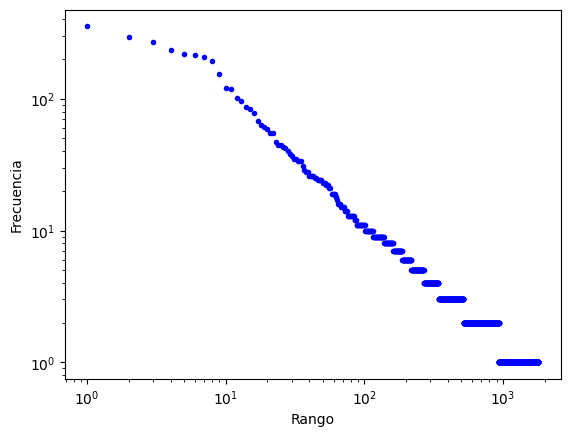

In [6]:
#@title ### Obtener el vocabulario del corpus

#@markdown Calcula las frecuencias de cada palabra que ocurra en el corpus incluyendo todos los documentos

# Además se calcula el número de palabras (tokens) totales en el corpus
# Y la frecuencia maxima en el vocabulario
vocabulario_completo = Vocabulario(corpus)
vocabulario_completo.imprimir_datos_vocabulario()

### Reducir el vocabulario

In [9]:
#@title ### Selección de criterio

#@markdown Dos formas de reducir el vocabulario son mantener en el vocabulario las N palabras con mayor frecuencia o mantener la palabras con una frecuencia mayor o igual a una frecuencia mínima. Las palabras que no cumplan el criterio se cambian por el token "\<UNK\>"
criterio = "Frecuencia minima" #@param ["N palabras", "Frecuencia minima"]


lenVocabulario = len(vocabulario_completo.palabras)
frecMaxima = vocabulario_completo.palabras.iloc[0]["Frecuencia"]
nSlider = widgets.IntSlider(value=int(lenVocabulario/2), max=lenVocabulario)
minFrecSlider = widgets.IntSlider(value=int(frecMaxima/2), max=frecMaxima)
if criterio == "N palabras":
  display(Markdown(f'**Selecciona el número N de palabras más frecuentes a conservar:**'))
  display(nSlider)
else:
  display(Markdown(f'**Selecciona la frecuencia mínima de las palabras a conservar:**'))
  display(minFrecSlider)

**Selecciona la frecuencia mínima de las palabras a conservar:**

IntSlider(value=177, max=355)

**Número total de palabras diferentes en el vocabulario reducido:**

936


**10 palabras con mayor frecuencia:**

       Frecuencia
<UNK>         859
de            355
que           295
no            270
y             235
la            219
en            214
el            207
me            193
a             154


**Mediana de las frecuencias de palabras**

3.0


**10 palabras con menor frecuencia:**

         Frecuencia
sueltos           2
planta            2
you               2
terreno           2
humo              2
to                2
her               2
copas             2
uno               2
salir             2


**Grafica Rango y Frecuencia:**

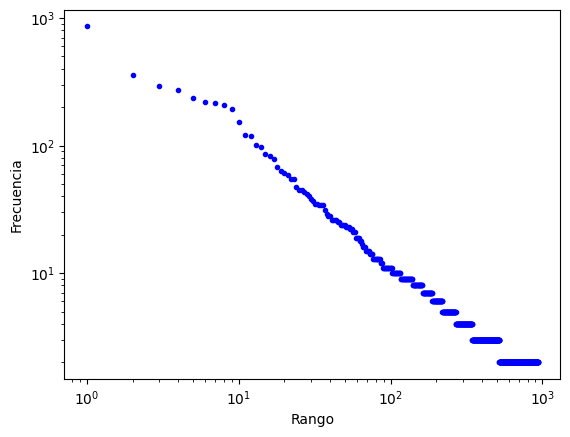

In [10]:
#@title Reducción del vocabulario
#@markdown Se reduce el vocabulario dependiendo el criterio y parametro elegido
if criterio == "N palabras":
  vocabularioEsqN = Vocabulario(corpus)
  vocabularioEsqN.reducir_vocabulario(criterio,nSlider.value)
  vocabularioEsqN.imprimir_datos_vocabulario()

else:
  vocabularioEsqMin = Vocabulario(corpus)
  vocabularioEsqMin.reducir_vocabulario(criterio,minFrecSlider.value)
  vocabularioEsqMin.imprimir_datos_vocabulario()


## Entrenamiento del modelo de N-gramas

**Explicacion de los parametros del modelo de Ngramas

In [21]:
#@title Selección de parametros del modelo
#@markdown Selecciona los parametros del modelo de Ngramas a crear

#@markdown `tam_ngrama`: Tamaño de los nGramas

#@markdown `reduccion`: Tipo de reducción de vocabulario a usar, o "ninguna" si se utiliza el vocabulario original
tam_ngrama = 4 #@param {type:"integer"}
reduccion = "Frecuencia minima" #@param ["N palabras", "Frecuencia minima", "Ninguna"]
suavizado = "Backoff" #@param ["Laplace", "Backoff"]

if reduccion == "N palabras":
  vocabularioParaModelo = vocabularioEsqN
elif reduccion == "Frecuencia minima":
  vocabularioParaModelo = vocabularioEsqMin
else:
  vocabularioParaModelo = vocabulario_completo

# Diccionario que almacena los nGramas construidos
modelos_entrenados = modelos_entrenados if "modelos_entrenados" in globals() else {}

# Entrena los modelos necesarios de nGramas
modelo_nuevo = Ngrama(tam_ngrama,vocabularioParaModelo,suavizado)
modelo_nuevo.entrenar(corpus)
modelos_entrenados[tuple([tam_ngrama,reduccion,suavizado])] = modelo_nuevo

display(Markdown(f'**10 conteos de {tam_ngrama}-gramas al azar**'))
for i in range(10):
  res = key, val = random.choice(list(modelo_nuevo.conteos.items()))
  print(res[0], "aparece",val, "veces")

display(Markdown(f'**10 probabilidades de {tam_ngrama}-gramas al azar**'))
print(modelo_nuevo.probabilidades.sample(10))

**10 conteos de 4-gramas al azar**

('y', 'entregame', 'esos', 'labios') aparece 1 veces
('que', 'se', '<UNK>', 'de') aparece 1 veces
('que', 'encontré', 'la', 'transmisión') aparece 1 veces
('dónde', 'estás?', 'dónde', 'estás?') aparece 3 veces
('<UNK>', 'cara', 'al', 'destino') aparece 1 veces
('frío', 'cuando', 'me', '<UNK>') aparece 1 veces
('ni', 'una', '<UNK>', 'la') aparece 1 veces
('manos', 'del', 'alma', 'de') aparece 1 veces
('<UNK>', 'pero', 'se', 'que') aparece 1 veces
('en', 'tu', 'dia', 'tanta') aparece 3 veces


**10 probabilidades de 4-gramas al azar**

                                probabilidad
(amor, y, recuerdos, de)            1.000000
(bienvenido, a, la, tierra)         1.000000
(noche, tu, <UNK>, <UNK>)           1.000000
(<UNK>, de, mi, vida)               0.333333
(sol, al, final, del)               1.000000
(al, sol, eso, ya)                  1.000000
(metal, neandertales, no, hay)      1.000000
(nube, para, que, se)               1.000000
(don´t, know, where, you)           0.500000
(el, <UNK>, te, <UNK>)              1.000000


In [ ]:
#@title Mostrar cuales modelos de nGramas ya estan entrenados y guardarlos en un diccionario



**Explicacion del caso en que no encuentre el contexto en el modelo seleccionado**

In [ ]:
#@title Calculo de probabilidades de N-gramas
#@markdown Calcula las probabilidades del modelo de N-gramas seleccionado
#@markdown `laplace`: Utiliza un suavizado de Laplace para el calculo de probabilidades de forma que:
#@markdown $$p(w_n|w_1^{n-1})=\frac{C(w_n|w_1^{n-1})+1}{\sum_{w\in V} C(w|w_1^{n-1})+|V|}$$


## Uso de los modelos de N-gramas

In [33]:
#@title Selección del modelo a usar

def imprimir_prob(palabra,prob,contexto):
  print("P("+palabra,end="",sep="")
  if(contexto != None and len(contexto) != 0): # Osea se utilizó algo de contexto
    print("|",end="")
    for j in range(len(contexto)-1):
      print(contexto[j]+",",end="")
    print(contexto[-1],end="")
  print(") = ",prob,sep="")

lista_modelos = [ key for key in modelos_entrenados]
lista_modelos_str = [ str(key) for key in modelos_entrenados]

seleccion_modelo = widgets.Dropdown(
    options=lista_modelos_str,
    value=lista_modelos_str[0],
    disabled=False,
)

display(Markdown(f'**Selecciona el modelo a usar:**'))
display(seleccion_modelo)

**Selecciona el modelo a usar:**

Dropdown(options=("(3, 'Frecuencia minima', 'Backoff')", "(3, 'Frecuencia minima', 'Laplace')", "(4, 'Frecuenc…

In [113]:
#@title Generación de oraciones aleatorias
#@markdown Genera una oración al azar de longitud menor o igual a M usando las probabilidades calculadas en el modelo de N-gramas

long_maxima = 10 #@param {type:"integer"}
reemplazar_UNK = False #@param {type:"boolean"}
mostrar_probabilidades = True #@param {type:"boolean"}

modelo = modelos_entrenados[lista_modelos[seleccion_modelo.index]]

oracion,extras = modelo.generar_oracion(long_maxima,reemplazar_UNK)

display(Markdown(f'**Oración generada al azar usando el modelo de N-gramas entrenado:**'))
for elemento in oracion:
  print(elemento,end=" ")
print()

if(mostrar_probabilidades):
  for i in range(len(extras)):
    imprimir_prob(oracion[i],extras[i][0],extras[i][1])

**Oración generada al azar usando el modelo de N-gramas entrenado:**

dicen que ya no hay guerra en mi mente tú 
P(dicen|<s>,<s>) = 0.015625
P(que|<s>,dicen) = 1.0
P(ya|dicen,que) = 0.5
P(no|que,ya) = 0.9047619047619048
P(hay|ya,no) = 0.07407407407407407
P(guerra|no,hay) = 0.03125
P(en|hay,guerra) = 1.0
P(mi|guerra,en) = 1.0
P(mente|en,mi) = 0.2
P(tú|mi,mente) = 0.25


In [125]:
#@title Obtención de palabras siguientes dado un contexto
#@markdown Da una palabra al azar que puede aparecer dado un contexto
contexto = "casi nunca dice que yo estoy enamorado de " #@param {type:"string"}

if contexto != "":
  oracion_contexto = ["<s>"]*(modelo.n-1) + contexto.split(" ")
else:
  oracion_contexto = ["<s>"]*(modelo.n-1)

modelo = modelos_entrenados[lista_modelos[seleccion_modelo.index]]

display(Markdown(f'**Oración transformada:**'))
print(modelo.transformar_oracion(oracion_contexto[modelo.n-1:]))

sig_palabra,prob,contexto_usado = modelo.siguiente_palabra(oracion_contexto[len(oracion_contexto)-modelo.n+1:])

display(Markdown(f'**Siguiente palabra escogida al azar con su respectiva probabilidad:**'))
print(sig_palabra)
imprimir_prob(sig_palabra,prob,contexto_usado)

**Oración transformada:**

['<UNK>', 'nunca', '<UNK>', 'que', 'yo', 'estoy', '<UNK>', 'de', '<UNK>']


**Siguiente palabra escogida al azar con su respectiva probabilidad:**

ya
P(ya|de,<UNK>) = 0.023809523809523808


In [34]:
#@title Probabilidad asignada a una oración
#@markdown Da la probabilidad que el modelo le asigna a la oración dada
oracion = "Y cuando sientas que no puedes m\xE1s" #@param {type:"string"}
mostrar_ngramas = True #@param {type:"boolean"}

if oracion != "":
  oracion_lista = oracion.split(" ")
else:
  oracion_lista = []

modelo = modelos_entrenados[lista_modelos[seleccion_modelo.index]]

display(Markdown(f'**Oración transformada:**'))
print(modelo.transformar_oracion(oracion_lista))

prob,extras = modelo.probabilidad_oracion(oracion_lista)

display(Markdown(f'**Probabilidad asignada a la oración:**'))
print(prob)

if(mostrar_ngramas):
  display(Markdown(f'**N-gramas calculados:**'))
  for i in range(len(extras)):
    imprimir_prob(extras[i][1][-1],extras[i][0],extras[i][1][:-1])

**Oración transformada:**

['<UNK>', 'cuando', '<UNK>', 'que', 'no', 'puedes', 'más']


**Probabilidad asignada a la oración:**

3.3747227327802745e-09


**N-gramas calculados:**

P(<UNK>|<s>,<s>) = 0.15625
P(cuando|<UNK>) = 0.0034924330616996507
P(<UNK>|cuando) = 0.10714285714285714
P(que|cuando,<UNK>) = 0.3333333333333333
P(no|<UNK>,que) = 0.13333333333333333
P(puedes|que,no) = 0.02857142857142857
P(más|no,puedes) = 1.0
P(<\s>|más) = 0.045454545454545456


## Evaluación de los modelos de n-gramas

**FIXME** Aqui poder poner una oracion y que se realize el mapa de calor con cada modelo entrenado hasta ahora y que tenga opcion para listar las probabilidades